<a href="https://colab.research.google.com/github/ibombonato/aicrowd-blitz-faceimages/blob/main/Detecto_Mask_Recognition_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Feb 22 11:58:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

![](https://images.aicrowd.com/raw_images/challenges/banner_file/1020/efe95338563ab47dda7e.png)

<h2><center> Getting Started with Mask Recognition Challenge</center></h2>

In this puzzle, we have detect mask type and bounding box of the mask from the image of human face. 

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be submitting the sample prediction directly in the required format.



 AIcrowd code utilities for downloading data for Language Classification


# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install detecto
!pip install pascal-voc-writer

In [ ]:
!pip install aicrowd-cli

     |████████████████████████████████| 50 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 7.9 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 170 kB 52.9 MB/s 
     |████████████████████████████████| 54 kB 3.6 MB/s 
     |████████████████████████████████| 214 kB 17.7 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 51 kB 8.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: pyzmq
    Found existing installation: pyzmq 22.3.0
    Uninstalling pyzmq-22.3.0:
      Successfully uninstalled pyzmq-22.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have

In [ ]:
!pip install --upgrade fastai


## Login to AIcrowd ㊗¶


In [ ]:
%load_ext aicrowd.magic
%aicrowd login

Please login here: https://api.aicrowd.com/auth/TH65wWSqHT_mCu4Zok3B_VdbNE97qvYMzVVDgL4_TYc
API Key valid
Gitlab access token valid
Saved details successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c mask-prediction -o data

sample_submission.csv:   0%|          | 0.00/44.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/115M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/193k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/318M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/82.8k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/137M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Diving in the dataset 🕵️‍♂️

In [ ]:
import torch
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from tqdm.auto import tqdm
import shutil
import glob
from ast import literal_eval
tqdm.pandas()

## Diving in the dataset 🕵️‍♂️

In [ ]:
train_images = 'data/train'
val_images = 'data/val'
test_images = 'data/test'

In [ ]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [ ]:
IMAGE_DIMS = (512, 512)

def format_bbox(annotation):
    xmin, ymin, xmax, ymax = annotation[0], annotation[1], annotation[2], annotation[3]
    width = xmax - xmin
    height = ymax - ymin
    return [{"xmin": xmin, "ymin": ymin, "width": width, "height": height}]

def make_df(df, path):
  df['bbox_list'] = [literal_eval(box) for box in df['bbox'].values]
  df['bbox_coco'] = df['bbox_list'].apply(lambda x: format_bbox(x)) 
  df['image']     = df['ImageID'].apply(lambda x: f"{path}/{x}.jpg")
  return df

In [ ]:
train_df = make_df(train_df, "/content/data/train/train")

In [ ]:
val_df = make_df(val_df, "/content/data/val/val")

In [ ]:
train_df.head()

,ImageID,bbox,masktype,bbox_list,bbox_coco,image
0,k8o0f,"[73, 197, 293, 400]",N95,"[73, 197, 293, 400]","[{'xmin': 73, 'ymin': 197, 'width': 220, 'height': 203}]",/content/data/train/train/k8o0f.jpg
1,7a0l9,"[47, 364, 300, 512]",surgical,"[47, 364, 300, 512]","[{'xmin': 47, 'ymin': 364, 'width': 253, 'height': 148}]",/content/data/train/train/7a0l9.jpg
2,wfp7p,"[203, 221, 380, 403]",N95,"[203, 221, 380, 403]","[{'xmin': 203, 'ymin': 221, 'width': 177, 'height': 182}]",/content/data/train/train/wfp7p.jpg
3,7qaw6,"[87, 210, 322, 385]",surgical,"[87, 210, 322, 385]","[{'xmin': 87, 'ymin': 210, 'width': 235, 'height': 175}]",/content/data/train/train/7qaw6.jpg
4,i4kqj,"[227, 283, 479, 475]",surgical,"[227, 283, 479, 475]","[{'xmin': 227, 'ymin': 283, 'width': 252, 'height': 192}]",/content/data/train/train/i4kqj.jpg


Detecto

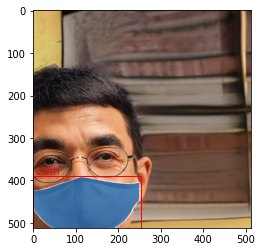

In [ ]:
from detecto import utils, visualize, core
import random

#train_files, train_labels, train_bboxes = get_labels(train_df)
rand_int = random.randint(0, len(train_df))

boxes=torch.FloatTensor(train_df.iloc[rand_int]['bbox_list'])
image = utils.read_image(train_df.iloc[rand_int]['image'])
label = train_df.iloc[rand_int]['masktype']
visualize.show_labeled_image(image, boxes, label)


In [ ]:
train_df.head()

,ImageID,bbox,masktype,bbox_list,bbox_coco,image
0,k8o0f,"[73, 197, 293, 400]",N95,"[73, 197, 293, 400]","[{'xmin': 73, 'ymin': 197, 'width': 220, 'height': 203}]",/content/data/train/train/k8o0f.jpg
1,7a0l9,"[47, 364, 300, 512]",surgical,"[47, 364, 300, 512]","[{'xmin': 47, 'ymin': 364, 'width': 253, 'height': 148}]",/content/data/train/train/7a0l9.jpg
2,wfp7p,"[203, 221, 380, 403]",N95,"[203, 221, 380, 403]","[{'xmin': 203, 'ymin': 221, 'width': 177, 'height': 182}]",/content/data/train/train/wfp7p.jpg
3,7qaw6,"[87, 210, 322, 385]",surgical,"[87, 210, 322, 385]","[{'xmin': 87, 'ymin': 210, 'width': 235, 'height': 175}]",/content/data/train/train/7qaw6.jpg
4,i4kqj,"[227, 283, 479, 475]",surgical,"[227, 283, 479, 475]","[{'xmin': 227, 'ymin': 283, 'width': 252, 'height': 192}]",/content/data/train/train/i4kqj.jpg


In [ ]:
from pascal_voc_writer import Writer

def create_voc(folder, df):
    files = glob.glob(folder+"/*")
    for i in range(len(files)):
        fid = files[i].replace(folder+'/','').split('.')[0]
        ldf=df[df['ImageID'] == fid].reset_index()
        if len(ldf)> 0:
            width, height = 512, 512
            writer = Writer(fid+'.jpg', width, height)
            for j in range(len(ldf)):
                writer.addObject(ldf['masktype'].iloc[j], 
                                 int(ldf['bbox_list'].iloc[j][0]), 
                                 int(ldf['bbox_list'].iloc[j][1]), 
                                 int(ldf['bbox_list'].iloc[j][2]),
                                 int(ldf['bbox_list'].iloc[j][3]))
            writer.save(folder+'/'+fid+'.xml')

In [ ]:
create_voc("/content/data/train/train", train_df)
create_voc("/content/data/val/val", val_df)

In [ ]:
LABELS = list(train_df['masktype'].unique())

In [ ]:
LABELS

['N95', 'surgical', 'cloth', 'KN95']

In [ ]:
dataset = core.Dataset('/content/data/train/train')
loader = core.DataLoader(dataset, batch_size=16, shuffle=True)
val_dataset = core.Dataset('/content/data/val/val')

In [ ]:
CHECKPOINT_FILE = "/content/drive/MyDrive/models/face-mask-detection/detector-checkpoint/model_weights.pth"
IS_RETRAIN = True
SHOULD_TRAIN = False

In [ ]:
if IS_RETRAIN:
  model = core.Model.load(CHECKPOINT_FILE, LABELS)
else:
  model = core.Model(LABELS)

In [ ]:
if SHOULD_TRAIN:
  losses = model.fit(loader, val_dataset, epochs=10, learning_rate=0.001, lr_step_size=5, verbose=True)
  print(losses)

Epoch 1 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:51<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.67it/s]


Loss: 0.01042639924014414
Epoch 2 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:42<00:00, 14.79it/s]


Loss: 0.010587748355125465
Epoch 3 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.72it/s]


Loss: 0.010518559506890597
Epoch 4 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:51<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:44<00:00, 14.58it/s]


Loss: 0.010279234234330943
Epoch 5 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.65it/s]


Loss: 0.010236767115517674
Epoch 6 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.66it/s]


Loss: 0.00948730687504091
Epoch 7 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.71it/s]


Loss: 0.00948224597639637
Epoch 8 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.70it/s]


Loss: 0.009637617039940476
Epoch 9 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:45<00:00, 14.47it/s]


Loss: 0.009566240358666012
Epoch 10 of 10
Begin iterating over training dataset


100%|██████████| 350/350 [10:50<00:00,  1.86s/it]


Begin iterating over validation dataset


100%|██████████| 2400/2400 [02:43<00:00, 14.67it/s]

Loss: 0.009637438047939213
[0.01042639924014414, 0.010587748355125465, 0.010518559506890597, 0.010279234234330943, 0.010236767115517674, 0.00948730687504091, 0.00948224597639637, 0.009637617039940476, 0.009566240358666012, 0.009637438047939213]


In [ ]:
model.save(CHECKPOINT_FILE)

In [ ]:
image = utils.read_image(train_df.iloc[rand_int]['image'])
predictions = model.predict(image)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


(['cloth'], tensor([[  0.0000, 390.1800, 252.1027, 512.0000]]), tensor([0.9999]))


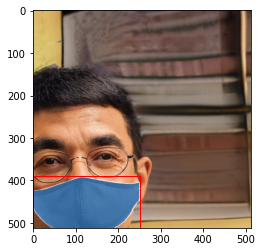

In [ ]:
print(predictions)
visualize.show_labeled_image(image, predictions[1])

In [ ]:
tfiles = glob.glob("/content/data/test/test/*")
#tfiles= tfiles[-3:]
predf=pd.DataFrame(columns=['ImageID', 'bbox', 'masktype'])
no_counter = 0
for i in tqdm(range(len(tfiles))):
  image = utils.read_image(tfiles[i])
  fid = tfiles[i].replace("/content/data/test/test/",'').split('.')[0]
  predictions = model.predict(image)
  labels, boxes, scores = predictions
  if len(boxes) == 0:
    boxes = torch.Tensor([[0, 0 , 0, 0]])
    labels = ['N95']
    no_counter += 1
  predf=predf.append({'ImageID': fid, 'bbox': list(boxes[0].tolist()), 'masktype': labels[0]}, ignore_index=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [ ]:
no_counter

1

In [ ]:
predf.head()

,ImageID,bbox,masktype
0,hm3nl,"[266.1948547363281, 176.89773559570312, 462.94873046875, 403.01171875]",N95
1,6bbrv,"[140.1844940185547, 302.0731506347656, 436.94476318359375, 511.5190124511719]",KN95
2,1sa11,"[180.58816528320312, 230.37953186035156, 450.2605895996094, 392.4754638671875]",KN95
3,astz6,"[186.33177185058594, 368.58404541015625, 409.1742248535156, 511.7454528808594]",cloth
4,iaxwc,"[342.2859191894531, 211.3665008544922, 512.0, 386.7083435058594]",cloth


# Predicting Mask Type outside Detector

In [ ]:
import fastai
fastai.__version__

'2.5.3'

In [ ]:
from pathlib import Path
import os

def create_dirs(labels, splits):
  for split in splits:
    for label in labels:
      os.makedirs(f"/content/images/{split}/{label}/", exist_ok=True)

def image_to_label_folder(img_name, label_directory, split_directory):
  origin = Path(f"/content/data/{split_directory}/{split_directory}/{img_name}.jpg")
  target = Path(f"/content/images/{split_directory}/{label_directory}/{img_name}.jpg")
  shutil.copy(origin, target)

def move_images(df, split):
  df.progress_apply(lambda x: image_to_label_folder(x["ImageID"],x["masktype"], split), axis=1)

In [ ]:
train_df.head()

,ImageID,bbox,masktype,bbox_list,bbox_coco,image
0,k8o0f,"[73, 197, 293, 400]",N95,"[73, 197, 293, 400]","[{'xmin': 73, 'ymin': 197, 'width': 220, 'height': 203}]",/content/data/train/train/k8o0f.jpg
1,7a0l9,"[47, 364, 300, 512]",surgical,"[47, 364, 300, 512]","[{'xmin': 47, 'ymin': 364, 'width': 253, 'height': 148}]",/content/data/train/train/7a0l9.jpg
2,wfp7p,"[203, 221, 380, 403]",N95,"[203, 221, 380, 403]","[{'xmin': 203, 'ymin': 221, 'width': 177, 'height': 182}]",/content/data/train/train/wfp7p.jpg
3,7qaw6,"[87, 210, 322, 385]",surgical,"[87, 210, 322, 385]","[{'xmin': 87, 'ymin': 210, 'width': 235, 'height': 175}]",/content/data/train/train/7qaw6.jpg
4,i4kqj,"[227, 283, 479, 475]",surgical,"[227, 283, 479, 475]","[{'xmin': 227, 'ymin': 283, 'width': 252, 'height': 192}]",/content/data/train/train/i4kqj.jpg


In [ ]:
labels = train_df['masktype'].unique()

create_dirs(labels, ["train", "val"])

In [ ]:
move_images(train_df, "train")
move_images(val_df, "val")

In [ ]:
from fastai.vision.all import *
path = '/content/images'

dls = ImageDataLoaders.from_folder(
    path, train='train', valid='val', item_tfms=Resize(224), 
                                        batch_tfms=aug_transforms(size=224))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


In [ ]:
learn = cnn_learner(dls, resnet34, metrics=[error_rate, accuracy])
learn.to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

SuggestedLRs(valley=0.0012022644514217973)

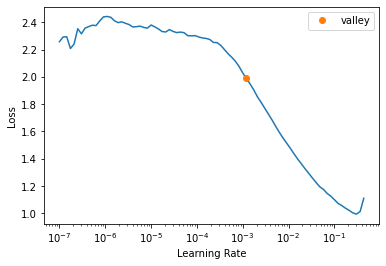

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(10, 0.0012022644514217973)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.000666,0.007708,0.002500,0.997500,01:01


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.000079,0.007182,0.002917,0.997083,01:04
1,0.000297,0.007953,0.001667,0.998333,01:06
2,0.004756,0.009327,0.002083,0.997917,01:02
3,0.006439,0.019123,0.004167,0.995833,01:03
4,0.004068,0.017757,0.003750,0.996250,01:02
5,0.002398,0.014002,0.002917,0.997083,01:01
6,0.001623,0.019084,0.002500,0.997500,01:02
7,0.001256,0.022495,0.003333,0.996667,01:02
8,0.000429,0.021484,0.003333,0.996667,01:02
9,0.001178,0.022142,0.003333,0.996667,01:02


In [ ]:
predf['image'] = predf['ImageID'].apply(lambda x: f"/content/data/test/test/{x}.jpg")

In [ ]:
test_dl_df = dls.test_dl(predf['image'])

In [ ]:
preds_test_df = learn.get_preds(dl=test_dl_df)
labelled_preds = [learn.dls.vocab[pred.argmax()] for pred in preds_test_df[0]]

In [ ]:
predf['masktype'] = labelled_preds
predf.drop(['image'], axis=1, errors='ignore', inplace=True)

In [ ]:
predf.head()

,ImageID,bbox,masktype
0,hm3nl,"[266.1948547363281, 176.89773559570312, 462.94873046875, 403.01171875]",N95
1,6bbrv,"[140.1844940185547, 302.0731506347656, 436.94476318359375, 511.5190124511719]",KN95
2,1sa11,"[180.58816528320312, 230.37953186035156, 450.2605895996094, 392.4754638671875]",KN95
3,astz6,"[186.33177185058594, 368.58404541015625, 409.1742248535156, 511.7454528808594]",cloth
4,iaxwc,"[342.2859191894531, 211.3665008544922, 512.0, 386.7083435058594]",cloth


## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [ ]:
!rm -rf assets
!mkdir assets
predf.to_csv(os.path.join("assets", "submission.csv"), index=False)


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c mask-prediction -a assets --no-verify

Using notebook: Detecto - Mask Recognition Challenge for submission...
Removing existing files from submission directory...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                   
                                                  │ Successfully submitted! │                                                   
                                                  ╰─────────────────────────╯

                                                        Important links                                                         
┌──────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions/175144              │
│                  │                                                                                                           │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/submissions?my_submissions=true │
│                  │                                                                                                           │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction/leaderboards                    │
│                  │                                                                                                           │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                             │
│                  │                                                                                                           │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/mask-prediction                                 │
└──────────────────┴───────────────────────────────────────────────────────────────────────────────────────────────────────────┘